In [0]:
# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 1.15.0
keras.__version__: 2.2.5


In [0]:
# Load Data (200 Images)
!cd /content
!git clone https://github.com/jeffreyAaron/Deep-Pi-Car

!git clone https://github.com/dctian/DeepPiCar

!ls
data_dir = '/content/DeepPiCar/models/lane_navigation/data/images'


fatal: destination path 'Deep-Pi-Car' already exists and is not an empty directory.
fatal: destination path 'DeepPiCar' already exists and is not an empty directory.
DeepPiCar  Deep-Pi-Car	sample_data


image_path: /content/Deep-Pi-Car/Images7/test_data_174_89.0.png
steering_Angle: 89


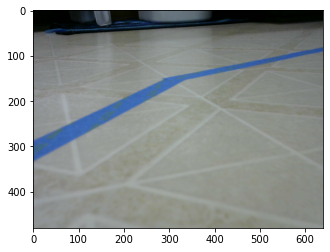

In [0]:
data_dir = '/content/Deep-Pi-Car/Images7'
file_list = os.listdir(data_dir)
image_paths = []
images = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(round(float(filename[-8+filename[-9:-4].find('_'):-4])))
        #angle = int(filename[-7:-4])
        steering_angles.append(angle)

image_index = 100
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

In [0]:

X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 160
Validation data: 40


In [0]:
model = Sequential(name='Nvidia_Model')
    
# elu=Expenential Linear Unit, similar to leaky Relu
# skipping 1st hiddel layer (nomralization layer), as we have normalized the data

# Convolution Layers
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(200, 200, 3), activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # not in original model. added for more robustness
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers
model.add(Flatten())
model.add(Dropout(0.2)) # not in original model. added for more robustness

model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))


model.add(Dense(1)) 


optimizer = Adam(lr=1e-3) # lr is learning rate
model.compile(loss='mse', optimizer=optimizer)

print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 48)        43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 64)        27712     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)            

In [0]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/2):,:,:] 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,200))
    image = image / 255 
    return image

In [0]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
      image = cv2.flip(image,1)
      steering_angle = 180+(steering_angle-90)
      pass
    if np.random.rand() < 0.5:
      zoom = img_aug.Affine(scale=(1, 1.3)) 
      image = zoom.augment_image(image)
      
    if np.random.rand() < 0.5:
      pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
      image = pan.augment_image(image)
    if np.random.rand() < 0.5:
      brightness = img_aug.Multiply((0.7, 1.3))
      image = brightness.augment_image(image)
    if np.random.rand() < 0.5:
      kernel_size = random.randint(1, 5)  
      image = cv2.blur(image,(kernel_size, kernel_size))
    return image, steering_angle

def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image



In [0]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment images
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [0]:
model_output_dir = "Deep-Pi-Car/SavedModels"
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
                              steps_per_epoch=300,
                              epochs=20,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1, 
                              callbacks=[checkpoint_callback])
                              

# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

Epoch 1/20
 67/300 [=====>........................] - ETA: 5:12 - loss: 2621.3764

KeyboardInterrupt: ignored

In [0]:
model = load_model('Deep-Pi-Car/SavedModels/lane_navigation_final.h5')
        
def compute_steering_angle(frame):
    preprocessed = img_preprocess(frame)
    X = np.asarray([preprocessed])
    steering_angle = model.predict(X)[0]
    return steering_angle

compute_steering_angle(cv2.imread(image_paths[100]))